In [1]:
!python --version

Python 3.10.1


# | P9 - Réalisez une application mobile de recommandation de contenu



<img src="https://user.oc-static.com/upload/2019/10/24/15719078448088_Capture%20d%E2%80%99e%CC%81cran%202019-10-24%20a%CC%80%2010.50.32.png">


## Contexte


En tant que CTO et cofondateur de la start-up My Content, qui vise encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs nous sommes en pleine construction d’un premier MVP qui prendra la forme d’une application mobile. 

Dans un premier temps, notre start-up souhaite tester une solution de recommandation d’articles et de livres à des particuliers.

Ne disposant pas de sufisement de données, nous faisons utiliserons le jeux de données disponible à l'adresse
[suivante](https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom).

En résumé, notre mission est la suivante :
- développer une première version de votre application mobile avec le système de recommandation que vous aurez développé ;
- stocker les scripts développés dans un dossier GitHub ;
- intégrer le système de recommandation à l'application mobile développée par Julien ;
- synthétiser vos premières réflexions sur :
- fournir l’architecture technique et la description fonctionnelle de votre application mobile à date, et le système de recommandation,
- fournir l’architecture cible pour pouvoir prendre en compte l’ajout de nouveaux utilisateurs ou de nouveaux articles, que vous présenterez à Samia.

# Observation du jeu de données


Le jeu de données utilisé lors de cette phase de construction du MVP est composé de trois fichiers et un répertoire :
1. <b>articles_embeddings.pickle</b>Contenant l'ensemble des articles du site https://www.globo.com/ sous forme d'embeding.


2. <b>articles_metadata.csv</b>Contenant l'ensemble des méta-donées relatives aux articles (id de l'article, id de la catégorie de l'article, date de craétion de l'article, id de l'auteur et nombre de mot de l'article).


3. <b>clicks_sample.csv</b> Contenant l'ensemble des informations relatives aux utilisateurs (id de l'utilisateur, id des sessions, date du début et de la session, taille de la session, id de l'article lu, date du click, environement/device et os de l'utilisateur, pays et regions de l'utilisateur).


4. <b>clicks.zip</b> Repertoir regroupant le détail des sessions des utilisateurs du 1er au 16 octobre 2017 pour près de 3 millions de clicks sur 385 fichiers .csv, les variable étant les mêmeqs que pour le jeu de données clicks_sample.csv :
- user_id : unique id for the user.
- session_id : unique id for an user's session. Can appear multiple times because multiple clicks per session.
- session_start : timestamp of the session. You must remove the 3 last numbers. Oldest session : 2017/10/01 2:37:3. 
- Newest session : 2017/10/1 3:39:19
- session_size : how many clicks per session. From 2 to 24. Distribution available few cells below.
- click_article_id : the article that has been cliked on.
- click_environment : no idea, maybe from website/app ? There is only three types, and the type 4 takes more than 90%.
- click_deviceGroup : must be the kind of device : computer, smartphone or tablet ?
- click_os : the operation system of the device.
- click_country : which country the user come from.
- click_region : same but for region.
- click_referrer_type : good question.

## Observation du jeu de donnée Articles_metadata

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_1 = pd.read_csv('./news-portal-user-interactions-by-globocom/articles_metadata.csv')
df_1.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


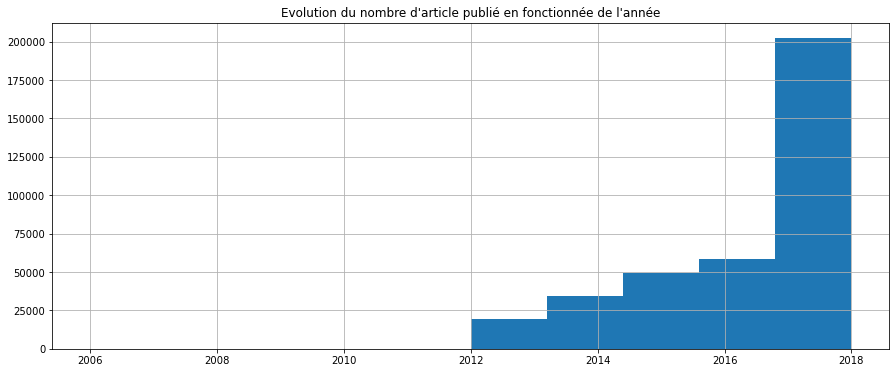

In [53]:

import time
plt.figure(figsize=(15,6))
plt.title("Evolution du nombre d'article publié en fonctionnée de l'année")
df_1.created_at_ts.apply(lambda x: time.localtime(x//1000)[0]).hist()
plt.show()

In [49]:
df_1.created_at_ts.apply(lambda x: time.localtime(x//1000)[0]).value_counts()

2017    155356
2016     58360
2015     49604
2018     46955
2014     34244
2013     18894
2012       341
2011       170
2010        61
2007        33
2009        13
2006         9
2008         7
Name: created_at_ts, dtype: int64

In [23]:
df_1

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [36]:
len(df_1[df_1.words_count == 0])

35

In [40]:
df_1[df_1.words_count != 0].words_count.argmin()

99000

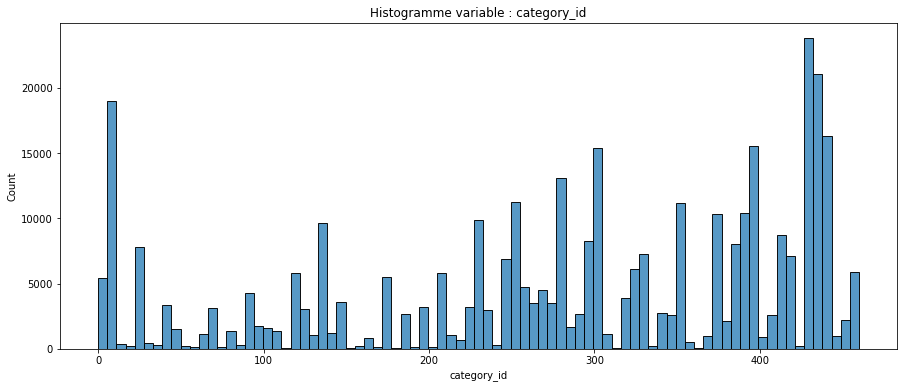

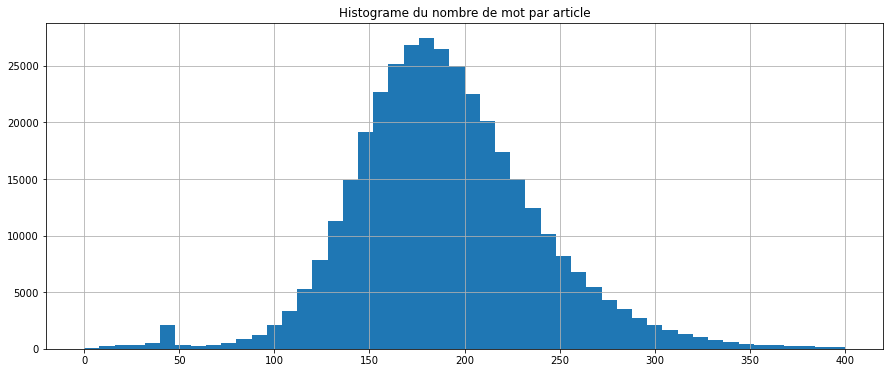

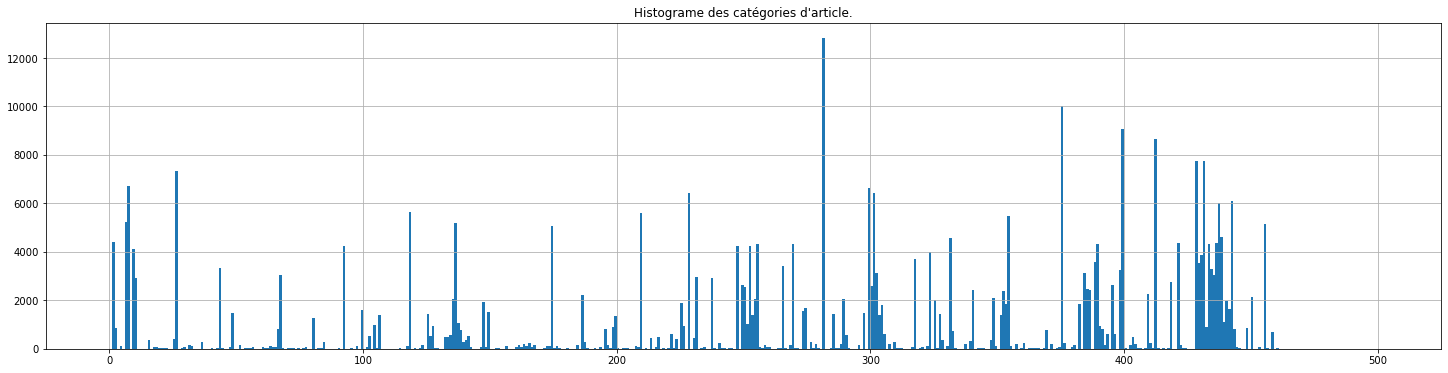

La moyenne du nombre de mot par article est de 190


In [4]:
plt.figure(figsize=(15,6))
plt.title(f'Histogramme variable : {df_1.columns[1]}')
sns.histplot(df_1.category_id)
plt.show()

plt.figure(figsize=(15,6))
plt.title('Histograme du nombre de mot par article')
df_1.words_count.hist(bins=50, range=(0,400))
plt.show()

plt.figure(figsize=(25,6))
plt.title("Histograme des catégories d'article.")
df_1.category_id.hist(bins=500, range=(0,500))
plt.show()
print(f'La moyenne du nombre de mot par article est de {int(df_1.words_count.mean())}')

Le jeu de données 'Articles_metadata' contient les informations des 364 047 utilisateurs connéectés du 1 au 16 octobre 2017.

## Observation du jeu de données Clicks_sample.csv

In [10]:
df_2 = pd.read_csv('./news-portal-user-interactions-by-globocom/clicks_sample.csv')
df_2

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


In [31]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1883 non-null   int64
 1   session_id           1883 non-null   int64
 2   session_start        1883 non-null   int64
 3   session_size         1883 non-null   int64
 4   click_article_id     1883 non-null   int64
 5   click_timestamp      1883 non-null   int64
 6   click_environment    1883 non-null   int64
 7   click_deviceGroup    1883 non-null   int64
 8   click_os             1883 non-null   int64
 9   click_country        1883 non-null   int64
 10  click_region         1883 non-null   int64
 11  click_referrer_type  1883 non-null   int64
dtypes: int64(12)
memory usage: 176.7 KB


In [25]:
df_2.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1.883000e+03,1883.000000,1883.000000,1.883000e+03,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,1.506828e+12,3.459904,176717.848646,1.506830e+12,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
std,206.162865,8.679628e+08,8.679468e+05,3.037467,82324.177259,1.064938e+07,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679
min,0.000000,1.506825e+15,1.506825e+12,2.000000,2137.000000,1.506827e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,1.506827e+12,2.000000,108854.000000,1.506828e+12,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,1.506828e+12,3.000000,157541.000000,1.506828e+12,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,1.506828e+12,4.000000,236697.500000,1.506829e+12,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,1.506829e+12,24.000000,363291.000000,1.506998e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


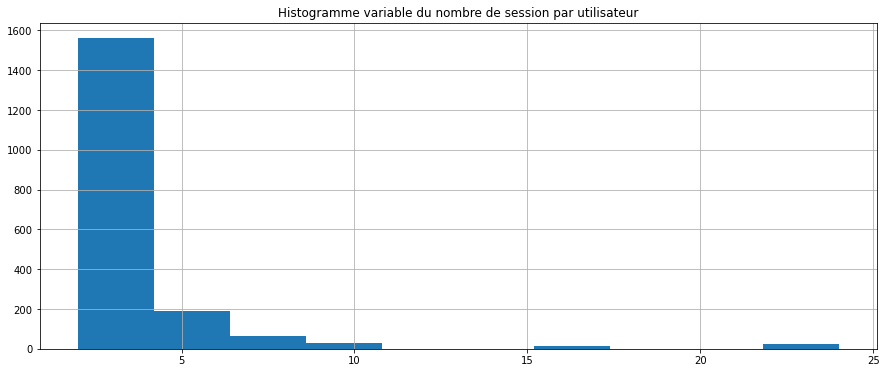

In [30]:
plt.figure(figsize=(15,6))
plt.title(f'Histogramme variable du nombre de session par utilisateur')
df_2.session_size.hist()
plt.show()

In [83]:
df_2
time.ctime
time.ctime(1506826828020//1000)

'Sun Oct  1 05:00:28 2017'

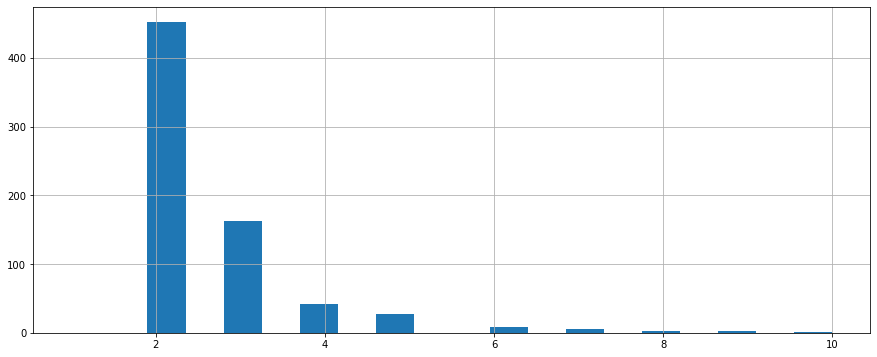

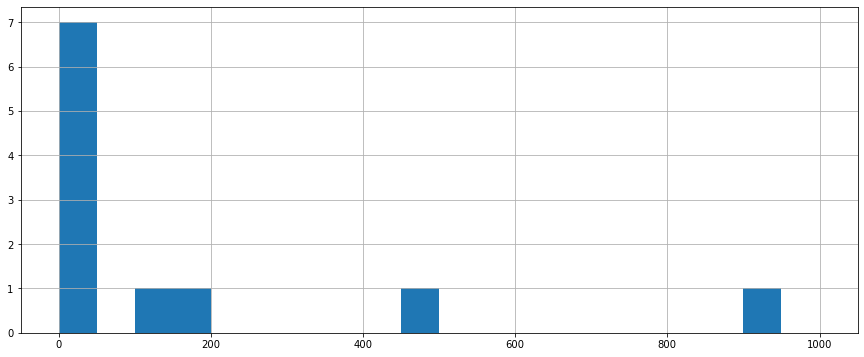

In [32]:
plt.figure(figsize=(15,6))
df_2.user_id.value_counts().hist(bins=20, range=(1,10))
plt.show()


plt.figure(figsize=(15,6))
df_2.session_size.value_counts().hist(bins=20, range=(0,1000))
plt.show()

In [16]:
df_2

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


In [14]:
df_2.user_id.nunique()

707

In [18]:
df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,15107,1507872960434128,1507872960000,4,20691,1507873325254,4,4,2,1,14,1
1308,15107,1507872960434128,1507872960000,4,327984,1507873616575,4,4,2,1,14,1
1309,15107,1507872960434128,1507872960000,4,172760,1507873646575,4,4,2,1,14,1
1310,294270,1507872968214129,1507872968000,2,96210,1507873274995,4,3,2,1,25,2


In [19]:
len(lisdir)

385

## Observation et regroupement des je de données Clicks.csv

In [11]:
%%time
import os
path_dir = './news-portal-user-interactions-by-globocom/clicks/'
lisdir = os.listdir(path_dir)

len(f'Le répertoire clicks.zip contient {len(lisdir)} fichiers .csv.')
df = pd.DataFrame()
for file in lisdir:
    df = pd.concat([df,pd.read_csv(path_dir+file)])
    
print(f"Une fois regroupé, le jeu de données contenant l'ensemble des clicks utilisateurs contient {len(df)} lignes.")
df.head()

Une fois regroupé, le jeu de données contenant l'ensemble des clicks utilisateurs contient 2988181 lignes.
CPU times: user 24.6 s, sys: 9.43 s, total: 34 s
Wall time: 34.3 s


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2


In [ ]:
df

Nous pouvons ici appercevoir le jeu de données regroupé par utilisateur.

In [140]:
%%time
df_groupby_user_id = df.groupby(['user_id', 'click_article_id']).sum()

CPU times: user 5.55 s, sys: 294 ms, total: 5.85 s
Wall time: 5.85 s


Par la suite nous utiliserons le jeu de données regroupant l'id des articles lu par les utilisateurs.

In [45]:
%%time
df_ = df.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)

print(f"En moyenne, les utilisateurs lisent {int(df_.LIST_click_article_id.apply(lambda x: len(x)).mean())} articles.")
df_

En moyenne, les utilisateurs lisent 9 articles.
CPU times: user 3.5 s, sys: 57 ms, total: 3.56 s
Wall time: 3.57 s


,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[327984, 183176, 235840, 96663, 59758, 160474,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236444, 234318, 233688, 237452, 235745, 12096..."
4,"[336499, 271261, 48915, 44488, 195887, 195084,..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


## Observation des articles sous forme d'embeding

In [5]:
%%time
import pickle

with open('./news-portal-user-interactions-by-globocom/articles_embeddings.pickle', 'rb') as f1:
    articles = pickle.load(f1)

CPU times: user 1.61 ms, sys: 79.3 ms, total: 81 ms
Wall time: 78.7 ms


In [7]:
articles.shape

(364047, 250)

In [54]:
%%time
import pickle

with open('./news-portal-user-interactions-by-globocom/articles_embeddings.pickle', 'rb') as f1:
    articles = pickle.load(f1)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(articles[:50000])

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
print(df_tsne.shape)

/Users/kevinduranty/miniforge3/envs/p8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(50000, 2)
CPU times: user 17min 42s, sys: 3min 29s, total: 21min 12s
Wall time: 3min 54s


In [60]:
tsne.

'euclidean'

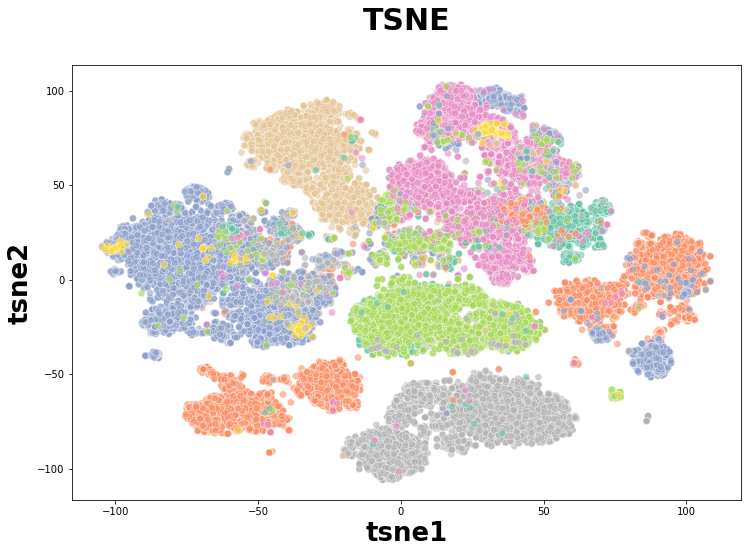

CPU times: user 1.07 s, sys: 12.9 ms, total: 1.08 s
Wall time: 545 ms


In [39]:
%%time
plt.figure(figsize=(12,8))

df_tsne["category_id"] = df_1["category_id"].head(50000)

sns.scatterplot(
    x="tsne1", y="tsne2",hue="category_id",
    palette=sns.color_palette('Set2',df_1["category_id"].head(50000).nunique()),
    data=df_tsne,s=50, alpha=0.6, legend=None)

plt.title('TSNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold') 

plt.show()

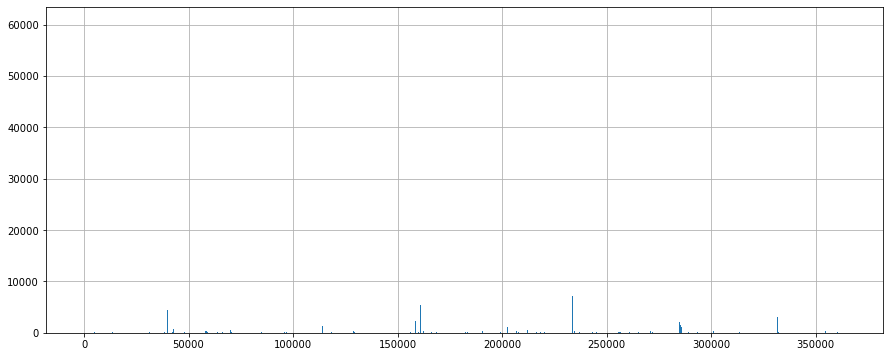

In [75]:
%%time
plt.figure(figsize=(15,6))
df.click_article_id.hist(bins=df.click_article_id.nunique())
plt.show()

In [77]:
df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,15107,1507872960434128,1507872960000,4,20691,1507873325254,4,4,2,1,14,1
1308,15107,1507872960434128,1507872960000,4,327984,1507873616575,4,4,2,1,14,1
1309,15107,1507872960434128,1507872960000,4,172760,1507873646575,4,4,2,1,14,1
1310,294270,1507872968214129,1507872968000,2,96210,1507873274995,4,3,2,1,25,2


KeyboardInterrupt: 

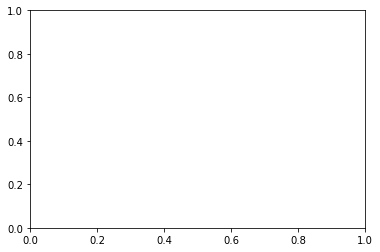

In [79]:
%%time
plt.figure(figsize=(15,6))
df.session_start.apply(lambda x: time.localtime(x//1000)[1:3]).hist()

In [ ]:
.apply(lambda x: time.localtime(x//1000)[0]).hist()

In [76]:
df.click_article_id.value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
283269        1
329065        1
38473         1
289316        1
164517        1
Name: click_article_id, Length: 46033, dtype: int64

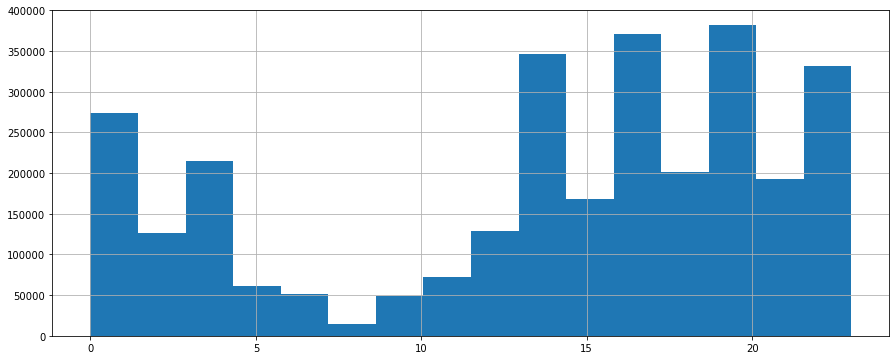

CPU times: user 1.72 s, sys: 57.9 ms, total: 1.78 s
Wall time: 1.69 s


In [94]:
%%time
plt.figure(figsize=(15,6))
df.click_timestamp.apply(lambda x: time.localtime(x//1000)[3]).hist(bins=16)
plt.show()

In [93]:
df.session_start.apply(lambda x: time.localtime(x//1000)[3]).value_counts()

13    211426
18    202832
19    188460
17    187703
20    180040
21    178182
16    175951
14    175914
15    172401
22    164333
12    156192
23    146355
0     137130
1     129286
2     123990
3     114515
4      87123
11     84574
5      55546
10     37621
6      29167
9      17467
7      17371
8      14602
Name: session_start, dtype: int64

# Systmèe de recommandation : Content-Based Filtering

## Recommandation en fonction de l'ensemble de lécture de l'utilisateur

In [21]:
%%time
import time
from scipy import spatial

def content_recommandation(df_article_by_user, user_id):
    cosine_similarity = spatial.distance.cosine
    df_1 = pd.read_csv('./news-portal-user-interactions-by-globocom/articles_metadata.csv')
    
    # Récupération de la liste des articles lus par l'utilisateur
    arts = df_article_by_user.iloc[user_id].values[0]
    
    
    # Liste des catégories lus par l'utilisateur
    list_art=np.array(list(set([df_1.iloc[arts[n]].category_id for n in range(len(arts))])))
    
    # Sélection des articles ayant les mêmes catégories d'article déja lus
    selection = df_1[df_1.category_id.isin(list_art)]
   # Retrai des article déja lus
    selection_ = selection[~df_1[df_1.category_id.isin(list_art)].article_id.isin(arts)]
    
    # Sélection des article en fonction du cosinus_simylarity
    cos = []
    for article in arts:
        for art in selection_.article_id:
            cos.append([article, art, cosine_similarity(articles[art].reshape(-1, 1), articles[article].reshape(-1, 1))])

    #Sélection de 5 articles en fonction des valeurs minimum de cos_similarity
    recommandation = []
    for n in range(5):
        recommandation.append(cos[np.array(cos)[:,2].argmin()])
        cos.remove(cos[np.array(cos)[:,2].argmin()])

    return np.array(recommandation)[:,1]

In [260]:
%%time
content_recommandation(df_article_by_user, 0)

CPU times: user 6.99 s, sys: 67.2 ms, total: 7.06 s
Wall time: 7.06 s


array([157514., 159284.,  92427., 157555., 162369.])

## Recommandation en fonction du dernier article lu par l'utilisateur

In [331]:
%%time
df['day'] = df.click_timestamp.apply(lambda x: time.localtime(x//1000)[2:5])


def recomndtions(user_id, df):
    cosine_similarity = spatial.distance.cosine
    #df_1 = pd.read_csv('./news-portal-user-interactions-by-globocom/articles_metadata.csv')
    # Sélection du dernier article lu par l'utilisateur
    df_temp = df[df.user_id == user_id][['click_article_id', 'day']]
    last_article_day = df_temp.day.max()
    last_article = df_temp[df_temp.day == last_article_day].click_article_id.values[0]

    # Liste des articles déja lue
    articles_read = df_temp.click_article_id.values

    # Dernier Article sous forme embeding lu par l'utilisateur
    last_read = articles[last_article]

    # Liste des catégorie lu par l'utilisateur
    list_caté_read = np.array(list(set([df_1.iloc[articles_read[n]].category_id 
                                        for n in range(len(articles_read))])))

    # Sélection des articles ayant les mêmes catégories que ceux lus par l'utilisateur
    selection = df_1[df_1.category_id.isin(list_caté_read)]

    # Retrait des articles déja lu par l'utilisateur
    selection_ = selection[~df_1[df_1.category_id.isin(list_caté_read)].article_id.isin(
        articles_read)].article_id.values

    score = [cosine_similarity(last_read, art) for art in articles[selection_]]



    recommandation = []
    for n in range(5):
        recommandation.append(np.array(score).argmin())
        score.pop(np.array(score).argmin())

    return recommandation

CPU times: user 1.48 s, sys: 100 ms, total: 1.58 s
Wall time: 1.61 s


In [332]:
%%time
recomndtions(8, df)

CPU times: user 2.36 s, sys: 18.4 ms, total: 2.37 s
Wall time: 2.37 s


[14829, 13133, 14944, 15836, 12622]

# Systmèe de recommandation : Collaborative Filtering

In [1]:
%%time
import os
import pandas as pd
import numpy as np

import scipy.sparse as sparse
import implicit
import collections
Counter = collections.Counter

path_dir = './news-portal-user-interactions-by-globocom/clicks/'
lisdir = os.listdir(path_dir)


df = pd.DataFrame()
for file in lisdir:
    df = pd.concat([df,pd.read_csv(path_dir+file)])
    
df = df.reset_index() 

df_1 = pd.read_csv('./news-portal-user-interactions-by-globocom/articles_metadata.csv')

df_2 = pd.read_csv('./news-portal-user-interactions-by-globocom/clicks_sample.csv')


df_article_by_user = df.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)

df_article_by_user['n_click'] = df.groupby('user_id')['session_size'].sum().values
df_article_by_user

df_user = pd.read_csv('UI/utiles/df_user.csv')
#df_article_by_user.to_csv('UI/utiles/df_user.csv')

CPU times: user 39.4 s, sys: 15.1 s, total: 54.5 s
Wall time: 53.4 s


In [167]:
df_article_by_user['n_click'] = df.groupby('user_id')['session_size'].sum().values


df_article_by_user.to_csv('UI/utiles/df_user.csv')

df_user = pd.read_csv('UI/utiles/df_user.csv')


In [161]:
np.save('UI/utiles/df_user', df_article_by_user.values)
np.save('test.np',df_article_by_user.LIST_click_article_id.values, )
df_article_by_user.to_csv('UI/utiles/df_user.csv')

In [526]:
%%time

#V1
# TFIDF des article lus en fonction des utilisateurs

def pars_matrice(df, articles, catégories, n_user=False, tfidf=False):
    """
    df : Dataframe['User_id', 'List_click_article']
    
    articles : array of all articles
    
    catégories : array of category by article
    
    n_user : int. Number of user in sparsMatrice
    
    """
    
    n_click = df.n_click.values
    if n_user==True:n_user = len(df)
        
    print(n_user)
    # TFIDF des article lus en fonction des utilisateurs
    user_tfidf = [np.isin(articles, 
                      df.LIST_click_article_id.values[n])
                       for n in range(n_user)]

    user_tfidf = np.array(user_tfidf)
    
    print(True,1)
    # Catégorie des articles lus
    user_tfidf = np.array([catégories * user_tfidf[n] for n in range(len(user_tfidf))])
    
    print(True,2)
    # Dictionnaire du nombre d'article lu par catégorie
    d = [Counter(user_tfidf[n]) for n in range(len(user_tfidf))]
    
    print(True,3)
    # Ajouts du nombre d'article lu dans la catégorie de l'article
    tfidf_ = [np.array([u for u in map(lambda x: d[n][x] if x != 0 else 0, user_tfidf[n])]) 
          for n in range(len(user_tfidf))]
    
    
    tfidf_ = [tfidf_[n]/n_click[n] for n in range(n_user)]
    print(True, 4)
    if tfidf:return np.array(tfidf_)
    return sparse.csr_matrix(np.array(tfidf_))



%%time
article_id = df_1.article_id.values
category_id = df_1.category_id.values

trainset = pars_matrice(df_article_by_user, article_id, category_id,n_user=50)

CPU times: user 19 µs, sys: 10 µs, total: 29 µs
Wall time: 34.1 µs


In [ ]:
%%time

def train_model(trainset):
    model = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)
    
    model.fit(user_items=trainset)
    
    return model


def predict(user_id, model, trainset):
    
    model.recommend(user_id, trainset[user_id])[0].tolist()
    
    

# TFIDF des article lus en fonction des utilisateurs

def pars_matrice(df, articles, n_user):
user_tfidf = [np.isin(df_1.article_id.values, 
                      df_article_by_user.LIST_click_article_id.values[n])
                       for n in range(3000)]

user_tfidf = np.array(user_tfidf)

In [7]:
#V2

class Model():
    def __init__(self, df, articles, catégories, n_user=True):
        """
        df : Dataframe['User_id', 'List_click_article']

        articles : array of all articles

        catégories : array of category by article

        n_user : int. Number of user in sparsMatrice

        """
        self.df = df
        self.articles = articles
        self.catégories = catégories
        self.n_user = n_user
    
    def pars_matrice(self):
        df = self.df
        articles = self.articles
        catégories = self.catégories
        n_user = self.n_user
        
        if n_user==True:n_user = len(df)

        print(n_user)
        # TFIDF des article lus en fonction des utilisateurs
        user_tfidf = [np.isin(articles, 
                          df.LIST_click_article_id.values[n])
                           for n in range(n_user)]

        user_tfidf = np.array(user_tfidf)

        print(True,1)
        # Catégorie des articles lus
        user_tfidf = np.array([catégories * user_tfidf[n] for n in range(len(user_tfidf))])

        print(True,2)
        # Dictionnaire du nombre d'article lu par catégorie
        d = [Counter(user_tfidf[n]) for n in range(len(user_tfidf))]

        print(True,3)
        # Ajouts du nombre d'article lu dans la catégorie de l'article
        tfidf_ = [np.array([u for u in map(lambda x: d[n][x] if x != 0 else 0, user_tfidf[n])]) 
              for n in range(len(user_tfidf))]

        print(True, 4)
        
        self.tfidf = np.array(tfidf_)
        self.sparse = sparse.csr_matrix(np.array(tfidf_))    
        return self
    
    
    def train_model(self,trainset):
        self.model = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)
        self.model.fit(user_items=trainset)
        return self
    
    def predict(self, user_id):
        return self.model.recommend(user_id, self.sparse[user_id])[0].tolist()
    
    def add_article(self, id_, catégorie_id):
        self.articles = np.append(self.articles, id_)
        self.catégories = np.append(self.catégories, catégorie_id)
        
    def add_user(self, user_id, article_read):
        self.df = sf.df.append(pd.DataFrame(data = {'LIST_click_article_id':[article_read]}, 
                                            index=[user_id]))
        

In [10]:
%%time
article_id = df_1.article_id.values
category_id = df_1.category_id.values
recomandation = Model(df_article_by_user, article_id, category_id,n_user=500).pars_matrice()

500
True 1
True 2
True 3
True 4
CPU times: user 46.5 s, sys: 1.25 s, total: 47.7 s
Wall time: 47.7 s


In [1]:
%%time
import os
import pandas as pd
import numpy as np

import scipy.sparse as sparse
import implicit
import collections

Counter = collections.Counter

path_dir = './news-portal-user-interactions-by-globocom/clicks/'
lisdir = os.listdir(path_dir)


df = pd.DataFrame()
for file in lisdir:
    df = pd.concat([df,pd.read_csv(path_dir+file)])
    
df = df.reset_index() 

df_1 = pd.read_csv('./news-portal-user-interactions-by-globocom/articles_metadata.csv')

df_2 = pd.read_csv('./news-portal-user-interactions-by-globocom/clicks_sample.csv')


df_article_by_user = df.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)

df_article_by_user['n_click'] = df.groupby('user_id')['session_size'].sum().values

CPU times: user 28.3 s, sys: 10.3 s, total: 38.6 s
Wall time: 36.4 s


In [8]:
#V3
import pandas as pd
import numpy as np

import scipy
import scipy.sparse as sparce
import pickle

import scipy.sparse
import implicit
import collections

import os

from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath


class My_Class():
    def __init__(self):
        self.ws = Workspace(subscription_id="d5bb9744-4790-446f-b7e1-591e22995cc7",
               resource_group="OpenClassrooms",
               workspace_name="OC_IA")

        self.datastore = Datastore.get(self.ws, 'workspaceblobstore')
        [os.remove(f"UI/utiles/{file}") for file in os.listdir('UI/utiles/')]
        self.datastore.download(target_path='.', prefix='UI/utiles')
        
    def add_user(self, user_id, article_read, n_click, publish=False):
        df = pd.read_csv('UI/utiles/df_user.csv')
        df = df.append(pd.DataFrame(data = {'LIST_click_article_id':[article_read],
                                                'n_click' : n_click
                                                }, 
                                            index=[user_id]))
        
    def add_article(self, id_, catégorie_id, publish=False):
        df_article = pd.read_csv('UI/utiles/df_article.csv',index_col='Unnamed: 0')
        df_article = df_article.append(pd.DataFrame(data = {'article_id':id_,
                                       'category_id':catégorie_id},
                               index=[id_]))
        
    def to_publish(self):
        
        for file in os.listdir('UI/utiles/'):
            try :
                self.datastore.blob_service.delete_blob('azureml-blobstore-f8554f92-a33d-430c-a1ff-4d9a166c55fc',
                                      f'UI/utiles/{file}')
            except:
                pass
        Dataset.File.upload_directory(src_dir='UI/utiles/',
                   target=DataPath(self.datastore, 'UI/utiles/'),
                   show_progress=True)
        
        print('Published on Azure Blob Storage')
        
    
    def sparse(self, n_user=True, publish=False, train=False):
        
        df = pd.DataFrame(np.load('UI/utiles/df_user.npy', allow_pickle=True), 
                          columns=['LIST_click_article_id', 'n_click'])
        df_article = pd.read_csv('UI/utiles/df_article.csv',index_col='Unnamed: 0')
        n_click = df.n_click.values
        articles = df_article.article_id
        categories = df_article.category_id
        n_user = n_user
        
        if n_user==True:n_user = len(df)

        # TFIDF des article lus en fonction des utilisateurs
        user_tfidf = [np.isin(articles, 
                          df.LIST_click_article_id.values[n])
                           for n in range(n_user)]

        user_tfidf = np.array(user_tfidf)

        # Catégorie des articles lus
        user_tfidf = np.array([categories * user_tfidf[n] 
                               for n in range(len(user_tfidf))])

        # Dictionnaire du nombre d'article lu par catégorie
        d = [Counter(user_tfidf[n]) for n in range(len(user_tfidf))]
        print('Parsing...')

        # Ajouts du nombre d'article lu dans la catégorie de l'article
        tfidf_ = [np.array([u for u in map(lambda x: d[n][x] if x != 0 else 0, 
                                           user_tfidf[n])])/n_click[n]
              for n in range(len(user_tfidf))]
        
        
        sparse_ = scipy.sparse.csc_matrix(np.array(tfidf_))
        scipy.sparse.save_npz('UI/utiles/sparse.npz', sparse_)
        print('Save !')
        if train:
            print('Train')
            self.train_model()
        
        if publish:
            self.to_publish()
        
    
    def train_model(self, publish=False):
        sparse_ = scipy.sparse.load_npz('UI/utiles/sparse.npz')
        self.model = implicit.als.AlternatingLeastSquares(factors=100,iterations=200,regularization=0.1)
        self.model.fit(sparse_)
        print('model trained successfuly')
        
        with open('UI/utiles/model.pkl', 'wb') as f1:
            pickle.dump(self.model, f1)
            print('model save !')
            
        if publish:
            self.to_publish()
            
    def predict(self, user_id):
        sparse_ = sparse.csr_matrix(scipy.sparse.load_npz('UI/utiles/sparse.npz'))
        return list(self.model.recommend(user_id, sparse_[user_id], 5)[0])

In [9]:
recomandation = My_Class()

Downloaded UI/utiles/sparse.npz, 1 files out of an estimated total of 5
Downloaded UI/utiles/df_article.csv, 2 files out of an estimated total of 5
Downloaded UI/utiles/df_user.npy, 3 files out of an estimated total of 5
Downloaded UI/utiles/df_user.csv, 4 files out of an estimated total of 5
Downloaded UI/utiles/model.pkl, 5 files out of an estimated total of 5


In [37]:
%%time
recomandation.sparse(50)

50
True
48.748284107635804
CPU times: user 5.02 s, sys: 204 ms, total: 5.23 s
Wall time: 5.22 s


In [12]:
recomandation.train_model()

/Users/kevinduranty/app/lib/python3.7/site-packages/implicit/utils.py:27: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/200 [00:00<?, ?it/s]

model trained successfuly
model save !


In [14]:
import scipy.sparse as sparse
recomandation.predict(5)

[4, 3, 2, 1, 0]

In [15]:
recomandation.to_publish()

Validating arguments.
Arguments validated.
Uploading file to UI/utiles/
Uploading an estimated of 4 files
Uploading UI/utiles/sparse.npz
Uploaded UI/utiles/sparse.npz, 1 files out of an estimated total of 4
Uploading UI/utiles/df_article.csv
Uploaded UI/utiles/df_article.csv, 2 files out of an estimated total of 4
Uploading UI/utiles/df_user.npy
Uploaded UI/utiles/df_user.npy, 3 files out of an estimated total of 4
Uploading UI/utiles/model.pkl
Uploaded UI/utiles/model.pkl, 4 files out of an estimated total of 4
Uploaded 4 files
Creating new dataset
Published on Azure Blob Storage
